In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm import tqdm

In [2]:
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, random
from jax import Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

In [3]:
def init_layer(key, in_dims: List[int], out_dim: int) -> List[Array]:
    """
    Initialize weight and bias terms for a layer that takes in inputs with
    dimensions in_dims and then outputs values with dimension out_dim.

    in_dims: dimensions of the input, i.e. in_dim[0] x 1, in_dim[1] x 1, ...
    out_dim: dimension of the output, i.e. out_dim x 1

    Return the weight matrices and bias vector for the layer.

    weight: out_dim x in_dim[0], out_dim x in_dim[1], ...
    bias: out_dim x 1
    """
    b_key, *w_keys = random.split(key, num=len(in_dims) + 1)
    weights = []
    for w_key, in_dim in zip(w_keys, in_dims):
        bound = jnp.sqrt(1 / in_dim)
        weight = random.uniform(w_key, (out_dim, in_dim), minval=-bound, maxval=bound)
        weights.append(weight)
    bias = random.uniform(b_key, (out_dim,), minval=-bound, maxval=bound)
    return weights + [bias]


def init_unet(key, sizes: List[int]) -> List[List[Array]]:
    """
    Initialize a U-Net style linear model with layer input and output
    dimensions from sizes. When sizes is of length N, the resulting model
    will contain 2 * (N-1) + 1 layers.

    key: random.PRNGKey(seed), used for randomness in initialization.
    sizes: list of integers to be used for layer dimension sizes.

    Return a list of layer parameters, where each layer is described as a
    list of the form: (weight, bias) for layers 1 through N and
    (prev_weight, res_weight, bias) for layers (N+1) through (2N-1).
    """
    n = len(sizes)
    key, *layer_keys = random.split(key, num=2 * n)

    model = []
    for i in jnp.arange(n - 1):
        # (weight, bias)
        layer = init_layer(layer_keys[i], [sizes[i]], sizes[i + 1])
        model.append(layer)

    # (weight, bias)
    layer = init_layer(layer_keys[n - 1], [sizes[n - 1]], sizes[n - 1])
    model.append(layer)

    for i in jnp.flip(jnp.arange(1, n)):
        # (prev_weight, res_weight, bias)
        layer = init_layer(
            layer_keys[n + i - 1], [sizes[i], sizes[i - 1]], sizes[i - 1]
        )
        model.append(layer)

    return model


In [4]:
# BEGIN SOLUTION
model = init_unet(random.PRNGKey(100), [9, 6, 4])
# END SOLUTION
for i, layer in enumerate(model):
    print(f"Layer {i}:")
    for j, weight in enumerate(layer[:-1]):
        print(f"\tW{j}: {weight.shape}")
    bias = layer[-1]
    print(f"\tb : {bias.shape}")

Layer 0:
	W0: (6, 9)
	b : (6,)
Layer 1:
	W0: (4, 6)
	b : (4,)
Layer 2:
	W0: (4, 4)
	b : (4,)
Layer 3:
	W0: (6, 4)
	W1: (6, 6)
	b : (6,)
Layer 4:
	W0: (9, 6)
	W1: (9, 9)
	b : (9,)


In [5]:
@jit
def sigmoid(x: Array) -> Array:
    """
    Compute the element-wise sigmoid of x.
    """
    return 0.5 * (jnp.tanh(x / 2) + 1)


@jit
def relu(x: Array) -> Array:
    """
    Compute the element-wise RELU of x.
    """
    return jnp.maximum(0, x)

In [6]:
@jit
def predict(model: List[List[Array]], x: Array) -> Array:
    """
    Return the prediction for x given the U-Net model.

    x: input to the model to be predicted
    """
    n = len(model)
    mid = n // 2

    res_x = []
    for i in range(0, mid):
        res_x.append(x)
        weight, bias = model[i]
        x = relu(jnp.dot(weight, x) + bias)
    
    weight, bias = model[mid]
    x = relu(jnp.dot(weight, x) + bias)

    for i in range(mid + 1, n):
        prev_weight, res_weight, bias = model[i]
        x = jnp.dot(prev_weight, x) + jnp.dot(res_weight, res_x.pop()) + bias
        if i < n - 1:
            x = relu(x)
            # x = sigmoid(x)

    return x


In [7]:
@jit
def mse_loss(output: Array, target: Array) -> Array:
    """
    Return the MSE (Mean Squared Error) loss between the target and output.
    """
    D = jnp.prod(jnp.array(target.shape))
    error = target - output
    return jnp.sum((error).dot(error)) / D


@jit
def forward_diffuse(x_init: Array, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x from the initial starting state, the given variance schedule,
    and the randomly sampled Gaussian noise.

    x_init: initial state
    var_schedule: variance schedule of length t (timesteps)
    noise: randomly sampled Gaussian noise for diffusing x_init

    Return value:
    x: state after diffusing x_init for t timesteps
    """
    alpha = jnp.prod(1 - var_schedule)
    return jnp.sqrt(alpha) * x_init + jnp.sqrt(1 - alpha) * noise


@jit
def reverse_diffuse(x: Array, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x_init from x (the state at t), the given variance schedule,
    and the predicted noise.

    x: state after diffusing x_init for t timesteps
    var_schedule: variance schedule of length t (timesteps)
    noise: predicted noise

    Return value:
    x_init: (predicted) initial state
    """
    alpha = jnp.prod(1 - var_schedule)
    return (x - jnp.sqrt(1 - alpha) * noise) / jnp.sqrt(alpha)

In [8]:
# vectorize these functions to be able to run minibatches of inputs
batched_predict = vmap(predict, in_axes=(None, 0))
batched_mse_loss = vmap(mse_loss, in_axes=(0, 0))
batched_forward_diffuse = vmap(forward_diffuse, in_axes=(0, None, 0))

In [9]:
@jit
def training_loss(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
) -> Array:
    """
    Compute the KL divergence loss with running the forward diffusion process
    for t timesteps, where t is uniformly sampled from the length of the
    variance schedule.
    """
    batch_size, n = x_init.shape
    noise = random.multivariate_normal(key, jnp.zeros(n), jnp.eye(n), shape=(batch_size, ))
    x = batched_forward_diffuse(x_init, var_schedule, noise)
    output_noise = batched_predict(model, x)
    return jnp.mean(batched_mse_loss(output_noise, noise))

@jit
def update(
    key,
    model: List[List[Array]],
    x: Array,
    step_size: float,
    var_schedule: Array,
) -> Tuple[Array, List[List[Array]]]:
    loss, grads = value_and_grad(training_loss, argnums=1)(key, model, x, var_schedule)

    updated_model = []
    for parameters, gradients in zip(model, grads):
        step = []
        for parameter, gradient in zip(parameters, gradients):
            step.append(parameter - step_size * gradient)
        updated_model.append(step)
    return loss, updated_model


In [10]:
# define input characteristics
input_shape = (3, 3)
input_dim = int(jnp.prod(jnp.array(input_shape)))
var_schedule = jnp.array([0.1 * i for i in range(1, 3)])

In [11]:
# key for reproducing randomness
key = random.PRNGKey(0)
# number of samples to generate
n = 10 #20 #50
# number of nonzero pixels per sample
pixels = 3

# generate indices where the sample will be nonzero
indices = random.uniform(key, shape=(n, pixels), minval=0, maxval=input_dim)

# generate training_data
samples = []
for sample_indices in indices:
    x = [0] * input_dim
    for index in sample_indices:
        x[int(index)] = 1
    samples.append(x)
training_data = jnp.array(samples)

print(training_data.shape)

(10, 9)


In [12]:
# initialize model
model_key = random.PRNGKey(1)
model = init_unet(model_key, [input_dim, 100, 1000])

# hyperparameters to be changed
step_sizes = [1, 0.5, 0.1]
batch_size = 10
num_epochs = 6000 #12000

In [13]:
training_key = random.PRNGKey(2)

# calculated values
key_index = 0
num_batches = len(training_data) // batch_size
keys = random.split(training_key, num=num_epochs * len(training_data))
epoch_progress = tqdm(range(num_epochs))

epoch_losses = []
for epoch in epoch_progress:
    if epoch < num_epochs // 3:
        step_size = step_sizes[0]
    elif epoch < num_epochs // 3 * 2:
        step_size = step_sizes[1]
    else:
        step_size = step_sizes[2]

    loss_values = []

    for i in range(num_batches):
        subkey = keys[key_index]
        x = training_data[i * batch_size : (i + 1) * batch_size]
        loss, model = update(subkey, model, x, step_size, var_schedule)
        loss_values.append(loss)

        # update tqdm progress bar with current loss
        epoch_progress.set_postfix_str(f"Loss {loss}")
        key_index += 1

    epoch_losses.extend(loss_values)

trained_model = model


100%|██████████| 6000/6000 [00:27<00:00, 217.69it/s, Loss 0.07202740758657455] 


Minimum epoch_loss found: 0.021560436114668846
Last loss found: 0.07202740758657455


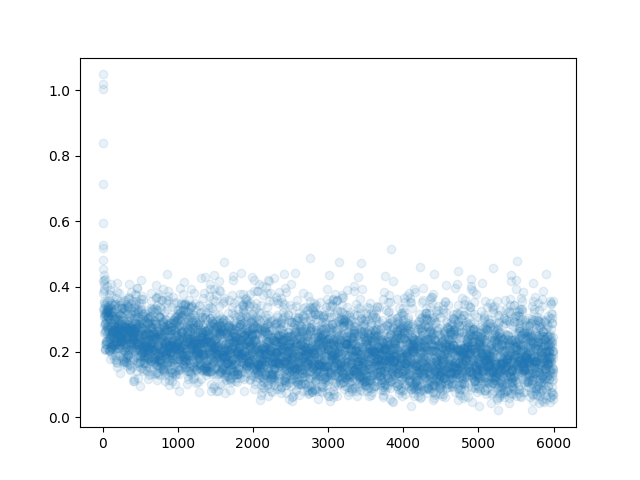

In [14]:
print(f"Minimum epoch_loss found: {jnp.min(jnp.array(epoch_losses))}")
print(f"Last loss found: {epoch_losses[-1]}")

for _ in range(20):
    # Close any prior plots
    plt.close()

plt.scatter(range(len(epoch_losses)), epoch_losses, alpha=0.1)
plt.show()

In [15]:
@jit
def diffuse_reconstruct(
    key, x_init: Array, var_schedule: Array, model: List[List[Array]]
) -> List[Array]:
    n = len(x_init)

    # calculate x_t and x_hat
    noise = random.multivariate_normal(key, jnp.zeros(n), jnp.eye(n))
    x_t = forward_diffuse(x_init, var_schedule, noise)
    output_noise = predict(model, x_t)
    x_hat = reverse_diffuse(x_t, var_schedule, output_noise)

    # compute losses
    reconstruction_loss = mse_loss(x_hat, x_init)
    noise_loss = mse_loss(output_noise, noise)

    # reshape states
    states = [x_init, x_t, x_hat]
    states = [x.reshape(input_shape) for x in states]

    # return the losses:
    # [reconstruction_loss, noise_loss]
    # and the states:
    # [initial state, diffused state, reconstructed initial state]
    return [reconstruction_loss, noise_loss], states


batched_diffuse_reconstruct = vmap(diffuse_reconstruct, in_axes=(0, 0, None, None))


def states_and_loss(key, data: Array, var_schedule: Array, model: List[List[Array]]) -> List[Array]:
    subkeys = random.split(key, num=len(data))

    losses, states = batched_diffuse_reconstruct(subkeys, data, var_schedule, model)
    for recon_loss, noise_loss in zip(losses[0], losses[1]):
        print(f"MSE loss: reconstruction: {recon_loss}, noise: {noise_loss}")

    return zip(states[0], states[1], states[2])

def show_states(state_visuals: List[List[Array]]):
    for states in state_visuals:
        n = len(states)
        _, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
        for i in range(n):
            # if i == 1:
            #     continue
            axs[i].imshow(states[i])
        plt.show()


MSE loss: reconstruction: 0.14238430559635162, noise: 0.366131067276001
MSE loss: reconstruction: 0.08530114591121674, noise: 0.21934576332569122
MSE loss: reconstruction: 0.0039953188970685005, noise: 0.010273677296936512
MSE loss: reconstruction: 0.07424271106719971, noise: 0.19090981781482697
MSE loss: reconstruction: 0.16919386386871338, noise: 0.43506985902786255
MSE loss: reconstruction: 0.0022965283133089542, noise: 0.005905365105718374
MSE loss: reconstruction: 0.005412435624748468, noise: 0.013917694799602032
MSE loss: reconstruction: 0.003794263582676649, noise: 0.009756673127412796
MSE loss: reconstruction: 0.008598094806075096, noise: 0.0221093837171793
MSE loss: reconstruction: 0.0006246164557524025, noise: 0.0016061558853834867


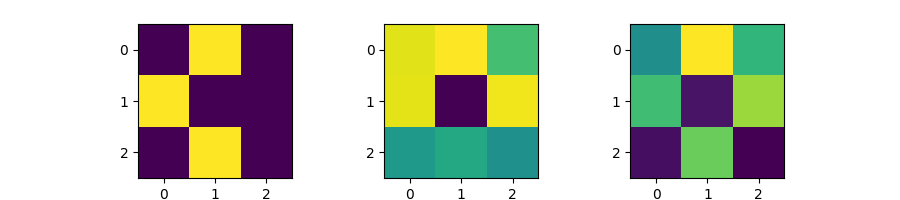

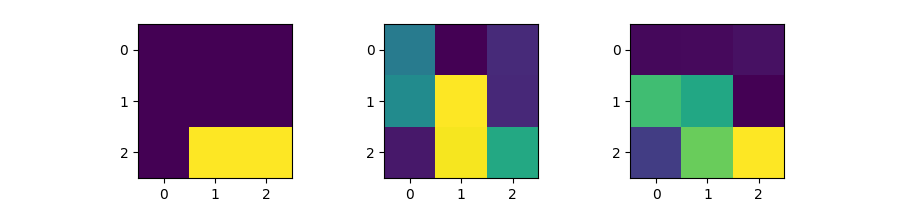

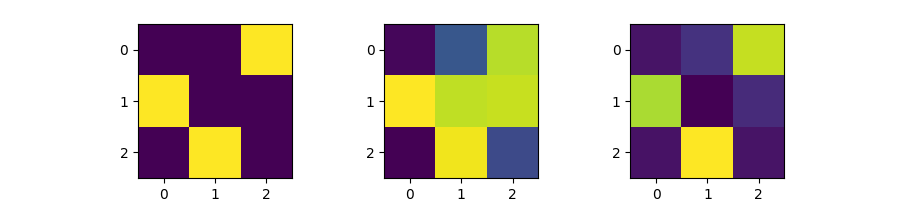

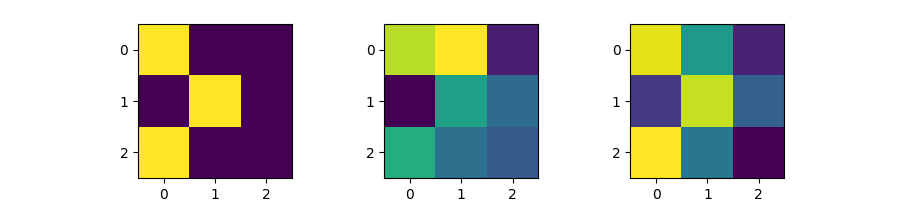

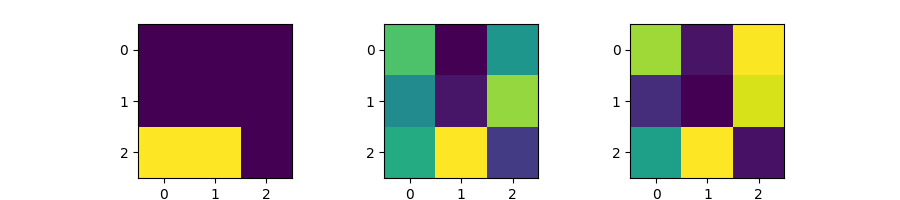

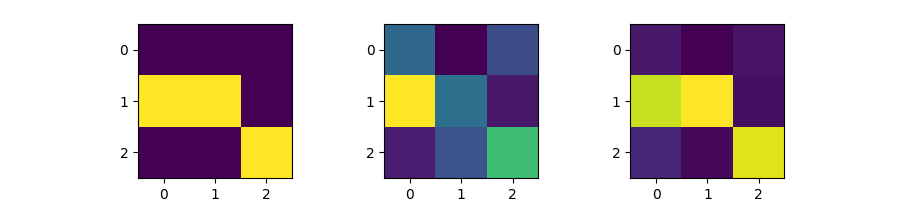

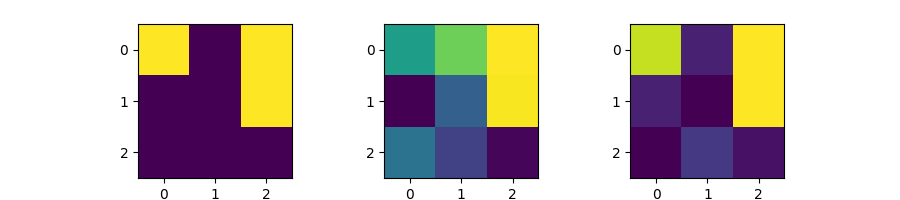

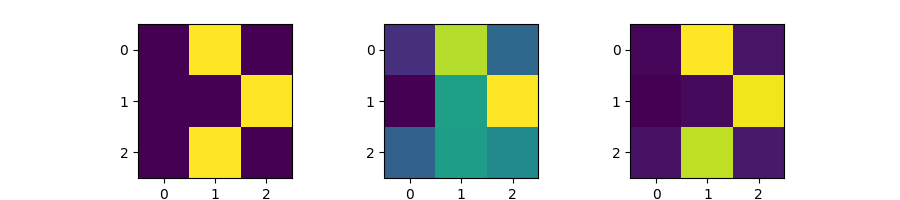

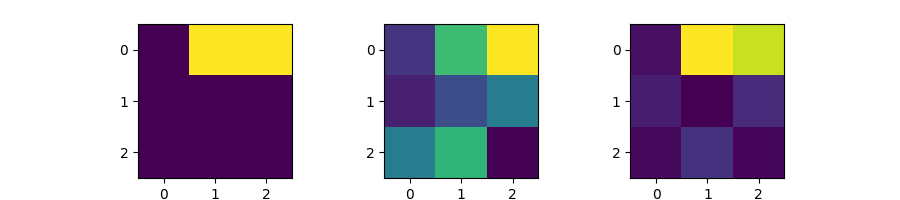

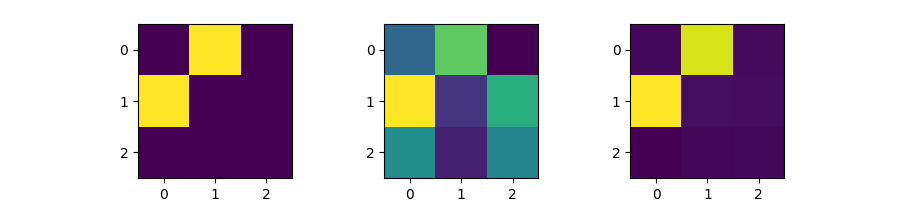

In [16]:
state_visuals = states_and_loss(random.PRNGKey(10), training_data, var_schedule, trained_model)
show_states(state_visuals)

MSE loss: reconstruction: 0.14037345349788666, noise: 0.3609602749347687
MSE loss: reconstruction: 0.25254836678504944, noise: 0.6494100689888


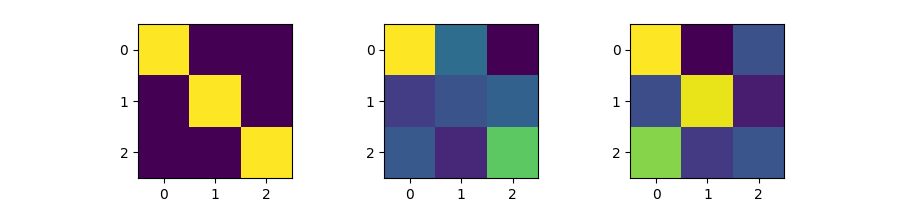

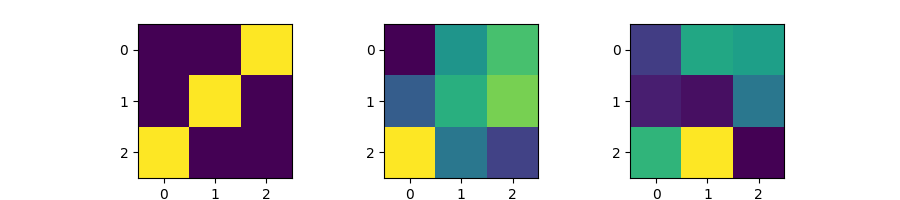

In [17]:
testing_data = jnp.array([
    jnp.eye(3).flatten(),
    jnp.flip(jnp.eye(3), axis=1).flatten(),
])

testing_state_visuals = states_and_loss(random.PRNGKey(11), testing_data, var_schedule, trained_model)
show_states(testing_state_visuals)

In [166]:
# uncomment and run this if there are too many plots open
# "Figure x" at the top of the current figure means there are x plots open;
# the notebook might complain once x >= 20

# for _ in jnp.arange(30):
#     plt.close()